觀察川普政策影響：
1. 4/7~4/14 波動
2. 3/27、3/28、3/31、4/1、4/2 發生前

先著重觀察 4/7 跌停 (尤其是夜盤)、4/10 漲停 (尤其是夜盤)
4/8、4/9
、4/11


備註：

期交所封包中，期貨價格/100，選擇權價格/1000

In [1]:
import binascii, os, glob, sys, time, datetime
import pandas as pd
import UDP
import os
import datetime
import re
import matplotlib.pyplot as plt
import ast
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties as font
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # 在圖表上顯示中文
import matplotlib.ticker as mtick
from collections import Counter
from datetime import datetime, timedelta

In [2]:
fut0407 = pd.read_csv(r'D:/委託與成交明細/成交/fut/處理後_夜盤_1140407.csv')
# 選擇4月份到期之台指期
fut0407 = fut0407[fut0407["商品名稱"] == 'MXFD5']
# 先將 object 轉成 list
fut0407["成交價格"] = fut0407["成交價格"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
fut0407["成交數量"] = fut0407["成交數量"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 取最後一筆成交價格與數量
fut0407["fut成交價格"] = fut0407["成交價格"].apply(lambda x: x[-1] if isinstance(x, list) and x else x)
fut0407["fut成交價格"] = fut0407["fut成交價格"] /100
fut0407["fut成交數量"] = fut0407["成交數量"].apply(lambda x: x[-1] if isinstance(x, list) and x else x)

fut0407 = fut0407.drop(columns=["流水序號", "成交價量(判斷有無穿價)", "成交價格", "成交數量"])
fut0407

,成交日期,成交時間,商品名稱,fut成交價格,fut成交數量
0,20250407,150000095,MXFD5,17693.0,3109
26,20250407,150000101,MXFD5,17693.0,2
30,20250407,150000101,MXFD5,17676.0,28
34,20250407,150000101,MXFD5,17676.0,34
36,20250407,150000102,MXFD5,17676.0,22
...,...,...,...,...,...
701752,20250408,45956269,MXFD5,18380.0,1
701758,20250408,45957469,MXFD5,18380.0,1
701759,20250408,45958087,MXFD5,18376.0,1
701760,20250408,45958265,MXFD5,18372.0,1


In [3]:
opt0407 = pd.read_csv(r'D:/委託與成交明細/成交/opt/處理後_夜盤_1140407.csv')
call = opt0407[opt0407['商品名稱'].str.contains(r'TXO.*D5', regex=True)]
put = opt0407[opt0407['商品名稱'].str.contains(r'TXO.*P5', regex=True)]

call0407 = call.copy()
put0407 = put.copy()

# 使用正則表達式提取履約價格
put0407['履約價格'] = put0407['商品名稱'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else None)
call0407['履約價格'] = call0407['商品名稱'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else None)

call0407_1 = call0407.copy()
put0407_1 = put0407.copy()

# 先將 object 轉成 list
call0407_1["成交價格"] = call0407_1["成交價格"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
call0407_1["成交數量"] = call0407_1["成交數量"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

put0407_1["成交價格"] = put0407_1["成交價格"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
put0407_1["成交數量"] = put0407_1["成交數量"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 取最後一筆成交價格與數量
call0407_1["call成交價格"] = call0407_1["成交價格"].apply(lambda x: x[-1] if isinstance(x, list) and x else x)
call0407_1["call成交價格"] = call0407_1["call成交價格"] /1000
call0407_1["call成交數量"] = call0407_1["成交數量"].apply(lambda x: x[-1] if isinstance(x, list) and x else x)

put0407_1["put成交價格"] = put0407_1["成交價格"].apply(lambda x: x[-1] if isinstance(x, list) and x else x)
put0407_1["put成交價格"] = put0407_1["put成交價格"] /1000
put0407_1["put成交數量"] = put0407_1["成交數量"].apply(lambda x: x[-1] if isinstance(x, list) and x else x)

call0407_1 = call0407_1.drop(columns=["流水序號", "成交價量(判斷有無穿價)", "成交價格","成交數量"])
put0407_1 = put0407_1.drop(columns=["流水序號", "成交價量(判斷有無穿價)", "成交價格","成交數量"])

## 策略
Long Call + Short Put vs Long Future

以Call當作
根據處理完的call0407_19000, put0407_19000去撰寫策略，幫我long call+short put，而且希望幫我盡量組出成交時間相同或近似的，最後要呈現出此策略的報酬圖形 (在0407夜盤當天的變化)

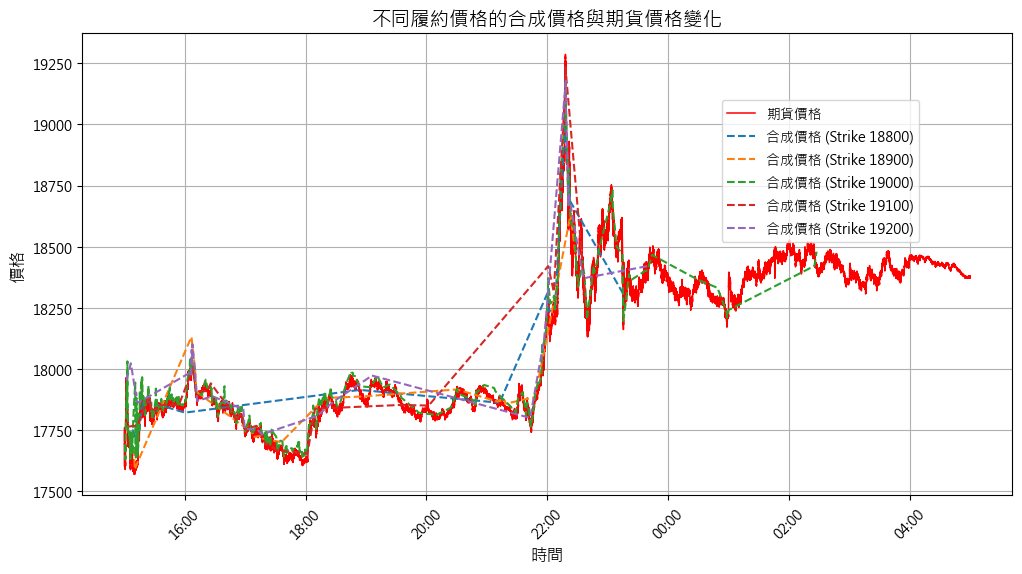

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def process_and_plot(fut_df, call_df, put_df, strike_prices):
    """
    處理期貨、買權、賣權數據，並繪製不同履約價格的合成價格走勢圖，包含期貨價格走勢。

    Parameters:
        fut_df (DataFrame): 期貨數據
        call_df (DataFrame): 買權數據
        put_df (DataFrame): 賣權數據
        strike_prices (list): 履約價格列表
    """
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # **繪製期貨價格走勢**
    fut_df = fut_df.copy()
    fut_df["時_分_秒"] = fut_df["成交時間"].astype(str).str.zfill(9).apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:6]}.{x[6:]}")
    fut_df["完整時間"] = pd.to_datetime(fut_df["成交日期"].astype(str) + " " + fut_df["時_分_秒"])
    fut_df.sort_values("完整時間", inplace=True)
    ax1.plot(fut_df["完整時間"], fut_df["fut成交價格"], label="期貨價格", color="red", linewidth=1.1)

    # **處理不同履約價格的合成價格**
    for strike_price in strike_prices:
        # 篩選指定履約價格的 Call / Put
        call_filtered = call_df[call_df["履約價格"] == strike_price].copy()
        put_filtered = put_df[put_df["履約價格"] == strike_price].copy()

        # 轉換成交時間為標準時間格式
        for df in [call_filtered, put_filtered]:
            df["時_分_秒"] = df["成交時間"].astype(str).str.zfill(9).apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:6]}.{x[6:]}")
            df["完整時間"] = pd.to_datetime(df["成交日期"].astype(str) + " " + df["時_分_秒"])
            df.sort_values("完整時間", inplace=True)

        # 合併 Call + Put
        call_put_df = pd.merge_asof(
            call_filtered, put_filtered, on="完整時間",
            direction="nearest", tolerance=pd.Timedelta(milliseconds=200)
        )

        # 合併期貨
        df = pd.merge_asof(
            fut_df, call_put_df, on="完整時間",
            direction="nearest", tolerance=pd.Timedelta(milliseconds=200)
        )

        # 過濾數據
        df_filtered = df.dropna(subset=["call成交價格", "put成交價格", "fut成交價格"]).copy()
        df_filtered.loc[:, "合成價格"] = df_filtered["call成交價格"] - df_filtered["put成交價格"] + strike_price

        # 繪製該履約價格的合成價格曲線
        ax1.plot(df_filtered["完整時間"], df_filtered["合成價格"], label=f"合成價格 (Strike {strike_price})", linestyle="--")

    # 設定 X 軸刻度格式與標題
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  
    plt.xticks(rotation=45)
    ax1.set_xlabel("時間", fontsize=12)
    ax1.set_ylabel("價格", fontsize=12)
    ax1.legend(loc="upper left", bbox_to_anchor=(0.68, 0.87))
    plt.title("不同履約價格的合成價格與期貨價格變化", fontsize=14)
    ax1.grid(True)

    # 顯示圖表
    plt.show()

# === 調用函數 ===
strike_prices = [18800, 18900, 19000, 19100, 19200]  # 需要繪製的履約價格
process_and_plot(fut0407, call0407_1, put0407_1, strike_prices)


In [32]:
# 篩選履約價格為 19000 的合約
strike = 18700
put0407_19000 = put0407_1[put0407_1['履約價格'] == strike]
call0407_19000 = call0407_1[call0407_1['履約價格'] == strike]

fut_df = fut0407.copy()
call_df = call0407_19000.copy()
put_df = put0407_19000.copy()

# 轉換 `成交時間` 為標準時間格式
fut_df["時_分_秒"] = fut_df["成交時間"].astype(str).str.zfill(9).apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:6]}.{x[6:]}")
call_df["時_分_秒"] = call_df["成交時間"].astype(str).str.zfill(9).apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:6]}.{x[6:]}")
put_df["時_分_秒"] = put_df["成交時間"].astype(str).str.zfill(9).apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:6]}.{x[6:]}")

# 合併 `成交日期` 和 `時_分_秒`，轉換為 datetime
fut_df["完整時間"] = pd.to_datetime(fut_df["成交日期"].astype(str) + " " + fut_df["時_分_秒"])
call_df["完整時間"] = pd.to_datetime(call_df["成交日期"].astype(str) + " " + call_df["時_分_秒"])
put_df["完整時間"] = pd.to_datetime(put_df["成交日期"].astype(str) + " " + put_df["時_分_秒"])

# 確保數據排序
fut_df = fut_df.sort_values("完整時間")
call_df = call_df.sort_values("完整時間")
put_df = put_df.sort_values("完整時間")

# === 合併 Call + Put ===
call_put_df = pd.merge_asof(
    call_df.sort_values("完整時間"),  # 確保時間排序
    put_df.sort_values("完整時間"),
    on="完整時間",
    direction="nearest",
    tolerance=pd.Timedelta(milliseconds=200)  # 設定時間誤差容忍範圍
)

# === 合併期貨 ===
df = pd.merge_asof(
    fut_df.sort_values("完整時間"),  # 期貨數據也要排序
    call_put_df,
    on="完整時間",
    direction="nearest",
    tolerance=pd.Timedelta(milliseconds=200)
)

# 只保留三者都有數據的行
#df.to_csv('PCP_Trump.csv', index = False, encoding = 'utf-8-sig')
df_filtered = df.dropna(subset=["call成交價格", "put成交價格", "fut成交價格"])
#df_filtered.to_csv('PCP_Trump_fliter.csv', index = False, encoding = 'utf-8-sig')

# === 計算合成價格 ===
df_filtered["合成價格"] = df_filtered["call成交價格"] - df_filtered["put成交價格"] + strike

# 計算盈虧
df_filtered["盈虧"] = df_filtered["fut成交價格"] - df_filtered["合成價格"]

df_filtered_18700 = df_filtered.loc[:, ["完整時間", "盈虧"]]



C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_2404\103245870.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["合成價格"] = df_filtered["call成交價格"] - df_filtered["put成交價格"] + strike
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_2404\103245870.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["盈虧"] = df_filtered["fut成交價格"] - df_filtered["合成價格"]


沒算手續費

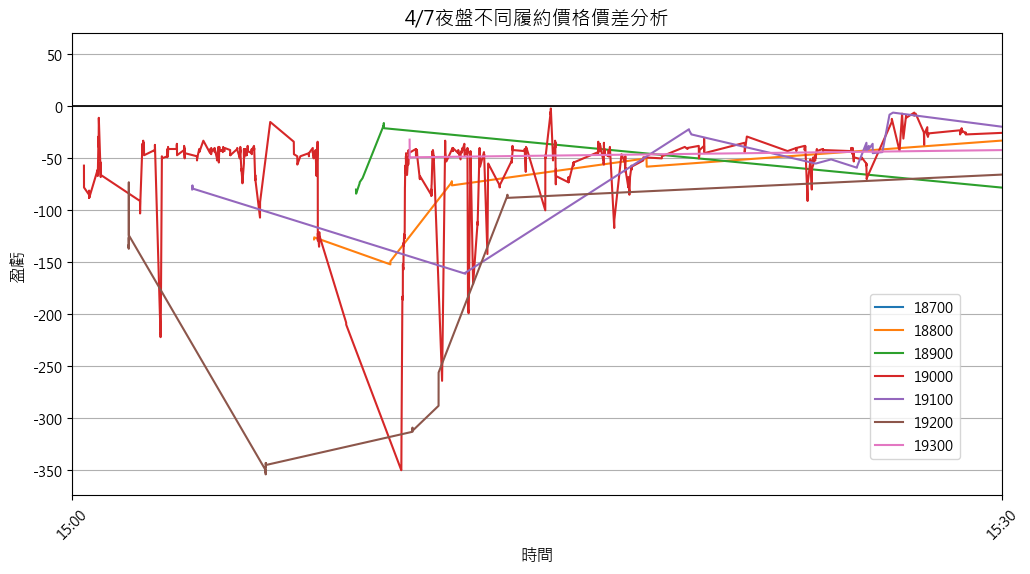

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# **合併所有 DataFrame**
df_combined = pd.concat([
    df_filtered_18700.assign(履約價格=18700),
    df_filtered_18800.assign(履約價格=18800),
    df_filtered_18900.assign(履約價格=18900),
    df_filtered_19000.assign(履約價格=19000),
    df_filtered_19100.assign(履約價格=19100),
    df_filtered_19200.assign(履約價格=19200),
    df_filtered_19300.assign(履約價格=19300)
], ignore_index=True)

# **繪製盈虧變化曲線**
fig, ax = plt.subplots(figsize=(12, 6))

# **迴圈繪製不同履約價格的曲線**
for strike_price in [18700, 18800, 18900, 19000, 19100, 19200, 19300]:
    df_filtered = df_combined[df_combined["履約價格"] == strike_price]
    ax.plot(df_filtered["完整時間"], df_filtered["盈虧"], label=f"{strike_price}")

# 設定 X 軸刻度，每 30 分鐘顯示一次
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 顯示 "時:分"
plt.xticks(rotation=45)  # 旋轉 X 軸標籤，避免重疊

# 設定 X 軸範圍，讓 15:00 是主要起點，但保留一點左側空間
start_time = pd.to_datetime("2025-04-07 15:00")  # 稍微提前 15 分鐘
end_time = pd.to_datetime("2025-04-07 15:30")  # 原設定結束時間
ax.set_xlim([start_time, end_time])

# **設定標題與軸標籤**
ax.set_xlabel("時間", fontsize=12)
ax.set_ylabel("盈虧", fontsize=12)
ax.axhline(0, color='black', linestyle='-', linewidth=1.25)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))  # 確保負號能正常顯示
plt.title("4/7夜盤不同履約價格價差分析", fontsize=14)

# **調整圖例位置**
ax.legend(loc="upper left", bbox_to_anchor=(0.85, 0.45))
ax.grid(True)

# **顯示圖表**
plt.show()


In [51]:
# 挑選價差最大的 3 個時間點，包含履約價格、完整時間與盈虧
top_3 = df_filtered_19300.nsmallest(10, "盈虧")[["完整時間", "盈虧"]]
print(top_3)

                          完整時間     盈虧
151691 2025-04-07 22:14:18.045 -105.0
151692 2025-04-07 22:14:18.052 -100.0
151690 2025-04-07 22:14:17.975  -99.0
151693 2025-04-07 22:14:18.088  -99.0
151689 2025-04-07 22:14:17.974  -98.0
32180  2025-04-07 16:10:02.344  -97.0
32181  2025-04-07 16:10:02.345  -96.0
32182  2025-04-07 16:10:02.417  -95.0
151686 2025-04-07 22:14:17.905  -95.0
151687 2025-04-07 22:14:17.905  -95.0


In [97]:
# 排除 15:00 ~ 16:00 的數據
filtered_df_19200 = df_filtered_19200[
    (df_filtered_19200["完整時間"] >= pd.to_datetime("2025-04-07 15:11")) &
    (df_filtered_19200["完整時間"] <= pd.to_datetime("2025-04-07 15:12:59"))
]

# 挑選價差最大的 3 個時間點，並包含週選合約價格與月選合成價格
top_3 = filtered_df_19200.nsmallest(10, "盈虧")[["完整時間", "盈虧"]]
print(top_3)

# 挑選價差最大的 3 個時間點，包含履約價格、完整時間與盈虧
#top_3 = df_filtered_19200.nsmallest(10, "盈虧")[["完整時間", "盈虧"]]
#print(top_3)

                         完整時間     盈虧
11535 2025-04-07 15:11:48.948 -288.0
11536 2025-04-07 15:11:48.950 -265.0
11537 2025-04-07 15:11:48.950 -265.0
11538 2025-04-07 15:11:48.967 -256.0
11539 2025-04-07 15:11:49.038 -256.0


In [ ]:
# 排除 15:00 ~ 16:00 的數據
filtered_df_19100 = df_filtered_19100[
    (df_filtered_19100["完整時間"] >= pd.to_datetime("2025-04-07 15:11")) &
    (df_filtered_19100["完整時間"] <= pd.to_datetime("2025-04-07 22:01"))
]

# 挑選價差最大的 3 個時間點，並包含週選合約價格與月選合成價格
top_3 = filtered_df_19100.nsmallest(10, "盈虧")[["完整時間", "盈虧"]]
print(top_3)

# 挑選價差最大的 3 個時間點，包含履約價格、完整時間與盈虧
#top_3 = df_filtered_19100.nsmallest(20, "盈虧")[["完整時間", "盈虧"]]
#print(top_3)

                          完整時間    盈虧
5278   2025-04-07 15:03:52.510 -80.0
5279   2025-04-07 15:03:52.525 -80.0
5280   2025-04-07 15:03:52.533 -80.0
5282   2025-04-07 15:03:52.584 -79.0
5281   2025-04-07 15:03:52.561 -76.0
190271 2025-04-07 22:38:05.076 -58.0
190270 2025-04-07 22:38:05.035 -57.0
190272 2025-04-07 22:38:05.124 -52.0
190273 2025-04-07 22:38:05.176 -52.0
190274 2025-04-07 22:38:05.239 -51.0


In [94]:
# 排除 15:00 ~ 16:00 的數據
filtered_df_19000 = df_filtered_19000[
    (df_filtered_19000["完整時間"] >= pd.to_datetime("2025-04-07 15:10:45")) &
    (df_filtered_19000["完整時間"] <= pd.to_datetime("2025-04-07 15:12:50"))
]

# 挑選價差最大的 3 個時間點，並包含週選合約價格與月選合成價格
top_3 = filtered_df_19000.nsmallest(10, "盈虧")[["完整時間", "盈虧"]]
print(top_3)

# 挑選價差最大的 3 個時間點，包含履約價格、完整時間與盈虧
#top_3 = df_filtered_19000.nsmallest(10, "盈虧")[["完整時間", "盈虧"]]
#print(top_3)


                         完整時間     盈虧
11579 2025-04-07 15:11:55.757 -264.0
12000 2025-04-07 15:12:47.044 -199.0
12001 2025-04-07 15:12:47.076 -199.0
12002 2025-04-07 15:12:47.275 -198.0
12003 2025-04-07 15:12:47.305 -198.0
11985 2025-04-07 15:12:45.844 -195.0
11986 2025-04-07 15:12:45.954 -195.0
11416 2025-04-07 15:11:34.852  -86.0
11421 2025-04-07 15:11:35.162  -86.0
11413 2025-04-07 15:11:34.639  -85.0


In [57]:
# 挑選價差最大的 3 個時間點，包含履約價格、完整時間與盈虧
top_3 = df_filtered_18900.nsmallest(10, "盈虧")[["完整時間", "盈虧"]]
print(top_3)

                         完整時間     盈虧
28674 2025-04-07 16:02:23.175 -173.0
28677 2025-04-07 16:02:23.282 -172.0
28680 2025-04-07 16:02:23.506 -172.0
28672 2025-04-07 16:02:23.156 -171.0
28673 2025-04-07 16:02:23.156 -171.0
28675 2025-04-07 16:02:23.183 -170.0
28676 2025-04-07 16:02:23.280 -170.0
28678 2025-04-07 16:02:23.293 -169.0
28679 2025-04-07 16:02:23.482 -169.0
31176 2025-04-07 16:06:29.150 -153.0


In [67]:
# 挑選價差最大的 3 個時間點，包含履約價格、完整時間與盈虧
top_3 = df_filtered_18800.nlargest(10, "盈虧")[["完整時間", "盈虧"]]
print(top_3)

                          完整時間    盈虧
157765 2025-04-07 22:17:23.761  35.0
157766 2025-04-07 22:17:23.799  35.0
157767 2025-04-07 22:17:23.814  35.0
157770 2025-04-07 22:17:23.829  35.0
157764 2025-04-07 22:17:23.681  34.0
27926  2025-04-07 16:00:03.895  33.0
157762 2025-04-07 22:17:23.680  32.0
157763 2025-04-07 22:17:23.681  32.0
157760 2025-04-07 22:17:23.678  31.0
157761 2025-04-07 22:17:23.680  31.0


In [56]:
# 挑選價差最大的 3 個時間點，包含履約價格、完整時間與盈虧
top_3 = df_filtered_18700.nsmallest(10, "盈虧")[["完整時間", "盈虧"]]
print(top_3)


                          完整時間    盈虧
125819 2025-04-07 21:55:23.876 -33.0
125822 2025-04-07 21:55:24.038 -33.0
125820 2025-04-07 21:55:23.916 -32.0
125821 2025-04-07 21:55:23.973 -32.0
125823 2025-04-07 21:55:24.065 -31.0
221539 2025-04-07 23:15:15.338 -30.0
221540 2025-04-07 23:15:15.382 -30.0
221541 2025-04-07 23:15:15.395 -30.0
135036 2025-04-07 22:02:20.754 -29.0
221532 2025-04-07 23:15:14.994 -29.0


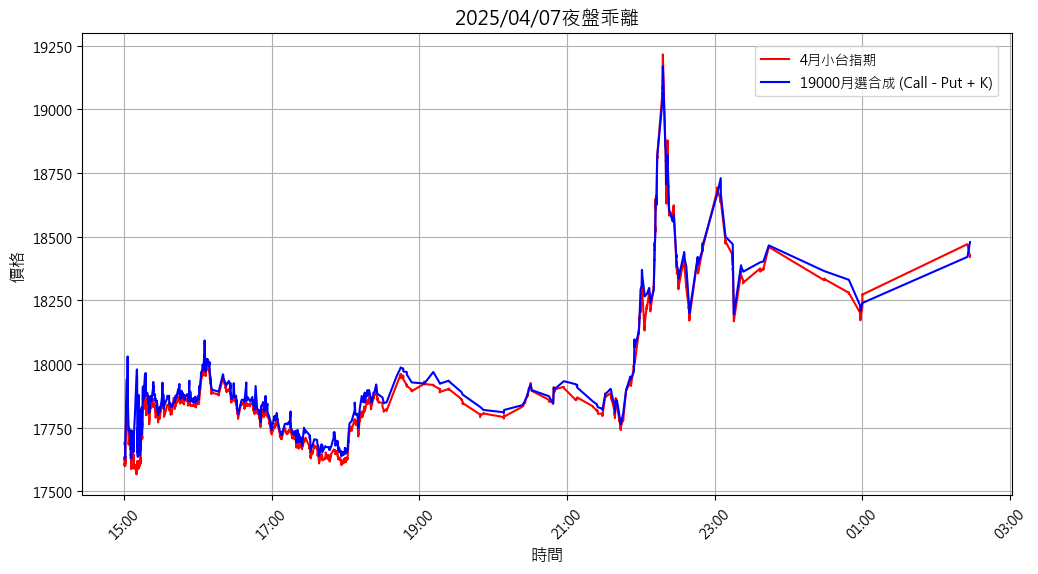

In [5]:
import matplotlib.dates as mdates

# === 計算合成價格 ===
#df_filtered["合成價格"] = df_filtered["call成交價格"] - df_filtered["put成交價格"] + 19000

# === 建立圖表 ===
fig, ax1 = plt.subplots(figsize=(12, 6))  # 設定圖表大小

# 左軸：期貨價格 vs 合成價格
ax1.plot(df_filtered["完整時間"], df_filtered["fut成交價格"], label="4月小台指期", color="red", markersize=4)
ax1.plot(df_filtered["完整時間"], df_filtered["合成價格"], label="19000月選合成 (Call - Put + K)", color="blue", markersize=4)

# 設定 Y 軸標籤
ax1.set_ylabel("價格", fontsize=12)
ax1.set_xlabel("時間", fontsize=12)
ax1.grid(True)

# 設定 X 軸刻度（只標示 4/7 夜盤的特定時間）
xticks_labels = pd.to_datetime([
    "2025-04-07 15:00", "2025-04-07 17:00", "2025-04-07 19:00",
    "2025-04-07 21:00", "2025-04-07 23:00", "2025-04-08 01:00",
    "2025-04-08 03:00"
])
ax1.set_xticks(xticks_labels)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 顯示 "時:分"
plt.xticks(rotation=45)  # 旋轉 X 軸標籤，避免重疊


# 調整圖例位置，使其更靠右
fig.legend(loc="upper left", bbox_to_anchor=(0.68, 0.87))  # 調整 X 軸位置

# 設定標題
plt.title("2025/04/07夜盤乖離", fontsize=14)

# 顯示圖表
plt.show()


In [6]:
df_filtered_19000 = df_filtered


In [7]:
df_filtered_19000 

,成交日期,成交時間,商品名稱,fut成交價格,fut成交數量,時_分_秒,完整時間,成交日期_x,成交時間_x,商品名稱_x,...,時_分_秒_x,成交日期_y,成交時間_y,商品名稱_y,履約價格_y,put成交價格,put成交數量,時_分_秒_y,合成價格,盈虧
958,20250407,150021605,MXFD5,17624.0,2,15:00:21.605,2025-04-07 15:00:21.605,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-65.0
959,20250407,150021605,MXFD5,17622.0,1,15:00:21.605,2025-04-07 15:00:21.605,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-67.0
960,20250407,150021610,MXFD5,17620.0,2,15:00:21.610,2025-04-07 15:00:21.610,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-69.0
961,20250407,150021614,MXFD5,17615.0,1,15:00:21.614,2025-04-07 15:00:21.614,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-74.0
962,20250407,150021662,MXFD5,17636.0,1,15:00:21.662,2025-04-07 15:00:21.662,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283507,20250408,22733028,MXFD5,18424.0,1,02:27:33.028,2025-04-08 02:27:33.028,20250408.0,22732922.0,TXO19000D5,...,02:27:32.922,20250408.0,22732922.0,TXO19000P5,19000.0,900.0,1.0,02:27:32.922,18479.0,-55.0
283508,20250408,22733029,MXFD5,18424.0,1,02:27:33.029,2025-04-08 02:27:33.029,20250408.0,22732922.0,TXO19000D5,...,02:27:32.922,20250408.0,22732922.0,TXO19000P5,19000.0,900.0,1.0,02:27:32.922,18479.0,-55.0
283509,20250408,22733054,MXFD5,18428.0,1,02:27:33.054,2025-04-08 02:27:33.054,20250408.0,22732922.0,TXO19000D5,...,02:27:32.922,20250408.0,22732922.0,TXO19000P5,19000.0,900.0,1.0,02:27:32.922,18479.0,-51.0
283510,20250408,22733055,MXFD5,18424.0,1,02:27:33.055,2025-04-08 02:27:33.055,20250408.0,22732922.0,TXO19000D5,...,02:27:32.922,20250408.0,22732922.0,TXO19000P5,19000.0,900.0,1.0,02:27:32.922,18479.0,-55.0


C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_2404\709841888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["盈虧"] = df_filtered["fut成交價格"] - df_filtered["合成價格"]
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


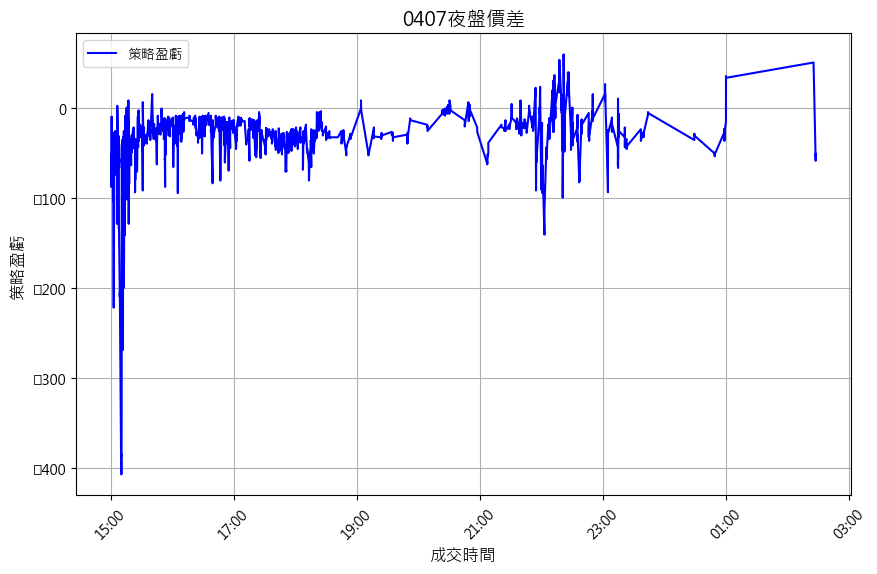

In [8]:
# 計算盈虧
df_filtered["盈虧"] = df_filtered["fut成交價格"] - df_filtered["合成價格"]

# 建立圖表
fig, ax = plt.subplots(figsize=(10, 6))

# 繪製盈虧曲線
ax.plot(df_filtered["完整時間"], df_filtered["盈虧"], linestyle="-", label="策略盈虧", color="blue")

# 設定 X/Y 軸標籤
ax.set_xlabel("成交時間", fontsize=12)
ax.set_ylabel("策略盈虧", fontsize=12)

# 設定 X 軸刻度（4/7 夜盤的特定時間點）
xticks_labels = pd.to_datetime([
    "2025-04-07 15:00", "2025-04-07 17:00", "2025-04-07 19:00",
    "2025-04-07 21:00", "2025-04-07 23:00", "2025-04-08 01:00",
    "2025-04-08 03:00"
])
ax.set_xticks(xticks_labels)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 顯示 "時:分"
plt.xticks(rotation=45)  # 確保標籤旋轉一次即可

# 設定標題、圖例與網格
plt.title("0407夜盤價差", fontsize=14)
ax.legend()
ax.grid(True)



# 顯示圖表
plt.show()


In [18]:
# 排除 15:07 ~ 15:11 的數據
filtered_df = df_filtered[
    (df_filtered["完整時間"] < pd.to_datetime("2025-04-07 15:00")) |
    (df_filtered["完整時間"] > pd.to_datetime("2025-04-07 15:14"))
]

# 選取價差最大的 3 個時間點，並包含期貨價格、月選合成價格
top_3 = filtered_df.nsmallest(3, "盈虧")[["完整時間", "盈虧", "fut成交價格", "合成價格"]]
print(top_3)


                          完整時間     盈虧  fut成交價格     合成價格
135897 2025-04-07 22:03:00.492 -141.0  18132.0  18273.0
135899 2025-04-07 22:03:00.663 -139.0  18134.0  18273.0
135896 2025-04-07 22:03:00.459 -137.0  18136.0  18273.0


In [13]:
df_filtered_1 = df_filtered[(df_filtered['成交時間'] >= 150000000) & (df_filtered['成交時間'] <= 151500000)]
df_filtered_1 

,成交日期,成交時間,商品名稱,fut成交價格,fut成交數量,時_分_秒,完整時間,成交日期_x,成交時間_x,商品名稱_x,...,時_分_秒_x,成交日期_y,成交時間_y,商品名稱_y,履約價格_y,put成交價格,put成交數量,時_分_秒_y,合成價格,盈虧
958,20250407,150021605,MXFD5,17624.0,2,15:00:21.605,2025-04-07 15:00:21.605,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-65.0
959,20250407,150021605,MXFD5,17622.0,1,15:00:21.605,2025-04-07 15:00:21.605,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-67.0
960,20250407,150021610,MXFD5,17620.0,2,15:00:21.610,2025-04-07 15:00:21.610,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-69.0
961,20250407,150021614,MXFD5,17615.0,1,15:00:21.614,2025-04-07 15:00:21.614,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-74.0
962,20250407,150021662,MXFD5,17636.0,1,15:00:21.662,2025-04-07 15:00:21.662,20250407.0,150022588.0,TXO19000D5,...,15:00:22.588,20250407.0,150022588.0,TXO19000P5,19000.0,1500.0,1.0,15:00:22.588,17689.0,-53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13536,20250407,151440190,MXFD5,17713.0,2,15:14:40.190,2025-04-07 15:14:40.190,20250407.0,151439635.0,TXO19000D5,...,15:14:39.635,20250407.0,151439635.0,TXO19000P5,19000.0,1450.0,2.0,15:14:39.635,17749.0,-36.0
13537,20250407,151440373,MXFD5,17715.0,4,15:14:40.373,2025-04-07 15:14:40.373,20250407.0,151439635.0,TXO19000D5,...,15:14:39.635,20250407.0,151439635.0,TXO19000P5,19000.0,1450.0,2.0,15:14:39.635,17749.0,-34.0
13538,20250407,151440428,MXFD5,17710.0,2,15:14:40.428,2025-04-07 15:14:40.428,20250407.0,151439635.0,TXO19000D5,...,15:14:39.635,20250407.0,151439635.0,TXO19000P5,19000.0,1450.0,2.0,15:14:39.635,17749.0,-39.0
13539,20250407,151440432,MXFD5,17717.0,2,15:14:40.432,2025-04-07 15:14:40.432,20250407.0,151439635.0,TXO19000D5,...,15:14:39.635,20250407.0,151439635.0,TXO19000P5,19000.0,1450.0,2.0,15:14:39.635,17749.0,-32.0


C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_2404\4164096125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_1["合成價格"] = df_filtered_1["call成交價格"] - df_filtered_1["put成交價格"] + 19000


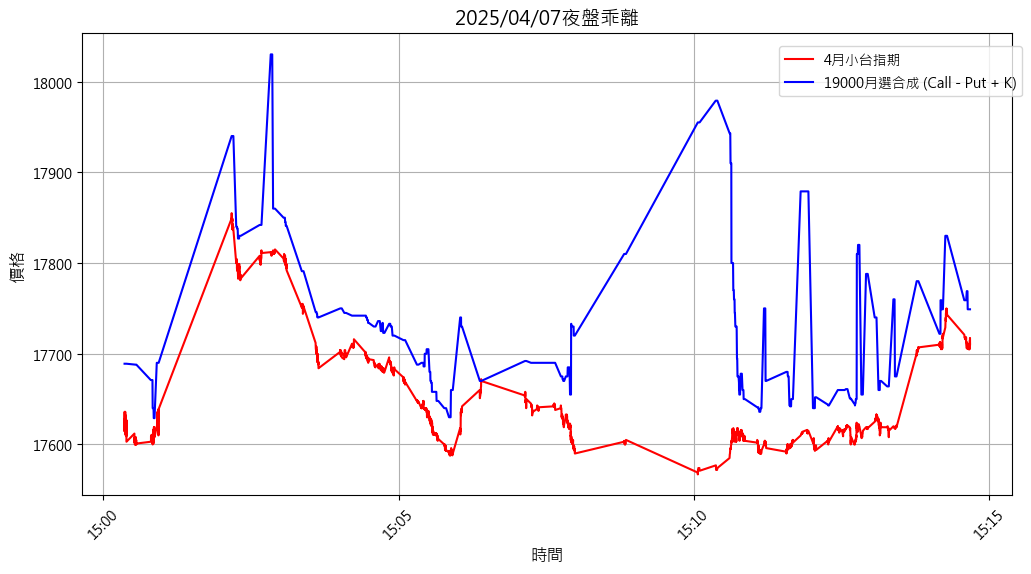

In [14]:
import matplotlib.dates as mdates

# === 計算合成價格 ===
df_filtered_1["合成價格"] = df_filtered_1["call成交價格"] - df_filtered_1["put成交價格"] + 19000

# === 建立圖表 ===
fig, ax1 = plt.subplots(figsize=(12, 6))  # 設定圖表大小

# 左軸：期貨價格 vs 合成價格
ax1.plot(df_filtered_1["完整時間"], df_filtered_1["fut成交價格"], label="4月小台指期", color="red", markersize=4)
ax1.plot(df_filtered_1["完整時間"], df_filtered_1["合成價格"], label="19000月選合成 (Call - Put + K)", color="blue", markersize=4)

# 設定 Y 軸標籤
ax1.set_ylabel("價格", fontsize=12)
ax1.set_xlabel("時間", fontsize=12)
ax1.grid(True)

# 設定 X 軸只顯示 "時:分"
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)  # 旋轉 X 軸標籤，避免重疊

# 調整圖例位置，使其更靠右
fig.legend(loc="upper left", bbox_to_anchor=(0.7, 0.87))  # 調整 X 軸位置

# 設定標題
plt.title("2025/04/07夜盤乖離", fontsize=14)

# 顯示圖表
plt.show()


C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_2404\2376480811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_1["盈虧"] = df_filtered_1["fut成交價格"] - df_filtered_1["合成價格"]
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


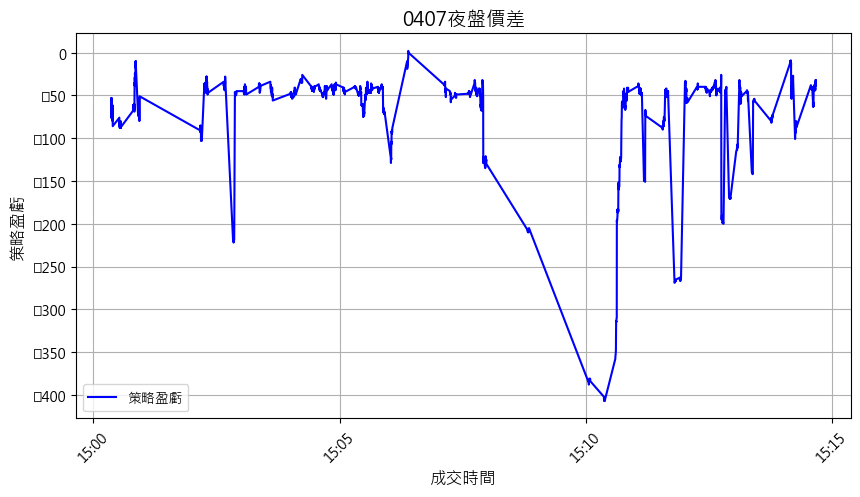

In [15]:
# 計算盈虧
df_filtered_1["盈虧"] = df_filtered_1["fut成交價格"] - df_filtered_1["合成價格"]

# 建立圖表
fig, ax = plt.subplots(figsize=(10, 5))

# 繪製盈虧曲線
ax.plot(df_filtered_1["完整時間"], df_filtered_1["盈虧"], linestyle="-", label="策略盈虧", color="blue")

# 設定 X/Y 軸標籤
ax.set_xlabel("成交時間", fontsize=12)
ax.set_ylabel("策略盈虧", fontsize=12)

# 設定 X 軸只顯示 "時:分"
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)  # 確保標籤旋轉一次即可

# 設定標題、圖例與網格
plt.title("0407夜盤價差", fontsize=14)
ax.legend()
ax.grid(True)



# 顯示圖表
plt.show()


考慮重新分組 (12點過後的數據，切的大小可以不同)